In [2]:
import os
import gc
import cv2
import time
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda import amp
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
import wandb
from sklearn.model_selection import StratifiedKFold

warnings.filterwarnings('ignore')


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [16]:
# 2. CONFIGURATION
# ====================================================
class CFG:
    # Paths
    BASE_PATH = "/kaggle/input/200-gold-standard-adni/200_AD_CN_MCI_11112025"
    CSV_PATH  = "/kaggle/input/metadatafor200gd/metadata.csv"
    OUTPUT_DIR = "/kaggle/working/outputs/"
    
    # Experiment
    project_name = "Alzheimers_Seg_k_fold_dice+losvez"
    run_name = "Unet++_DiceLovasz_200img"
    seed = 42
    
    # Model
    arch = "UnetPlusPlus"
    backbone = "efficientnet-b0"
    weights = "imagenet"
    
    # Training Params
    n_folds = 5
    img_size = 256
    batch_size = 16
    epochs = 100        # Increased for Early Stopping
    lr = 1e-4
    
    # Regularization
    weight_decay = 1e-2          # For AdamW
    max_grad_norm = 1000         # Gradient Clipping
    early_stopping_patience = 15 # Wait 15 epochs before stopping
    early_stopping_delta = 1e-4
    
    # Scheduler
    scheduler_T_max = epochs
    scheduler_min_lr = 1e-6

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_workers = 2

# Create output dir
os.makedirs(CFG.OUTPUT_DIR, exist_ok=True)

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(CFG.seed)

In [5]:
# 3. WANDB LOGIN
# ====================================================
from kaggle_secrets import UserSecretsClient
try:
    user_secrets = UserSecretsClient()
    wandb.login(key=user_secrets.get_secret("wandb_api"))
    print("✅ Logged in to WandB")
except:
    print("⚠️ WandB login failed. Running in offline mode.")
    wandb.init(mode="disabled")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: utkarsh3104-imp (alzhemer_segmentaion) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


✅ Logged in to WandB


In [8]:
# 4. DATA PREPARATION
# ====================================================
def get_data():
    df = pd.read_csv(CFG.CSV_PATH)
    df['image_path'] = df['image_id'].apply(lambda x: os.path.join(CFG.BASE_PATH, 'images', x))
    df['mask_path'] = df['mask_id'].apply(lambda x: os.path.join(CFG.BASE_PATH, 'masks', x))
    df['class'] = df['image_id'].apply(lambda x: x.split('_')[0].upper())
    return df

df_all = get_data()

In [9]:
class BrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = cv2.imread(row['image_path'], cv2.IMREAD_GRAYSCALE)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        mask = cv2.imread(row['mask_path'], cv2.IMREAD_GRAYSCALE)
        mask = np.where(mask > 127, 1.0, 0.0)
        
        if self.transform:
            aug = self.transform(image=img, mask=mask)
            img = aug['image']
            mask = aug['mask']
            
        if mask.ndim == 2: mask = mask.unsqueeze(0)
        return img, mask.float()

def get_transforms(data):
    if data == 'train':
        return A.Compose([
            A.Resize(CFG.img_size, CFG.img_size),
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5),
            A.OneOf([
                A.GridDistortion(num_steps=5, distort_limit=0.3, p=1.0),
                A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
            ], p=0.3),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ])
    else:
        return A.Compose([
            A.Resize(CFG.img_size, CFG.img_size),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ])

In [10]:
def build_model():
    model = smp.UnetPlusPlus(
        encoder_name=CFG.backbone, 
        encoder_weights=CFG.weights, 
        in_channels=3, 
        classes=1, 
        activation=None
    )
    return model.to(CFG.device)

# --- LOSS DEFINITIONS ---
dice_loss = smp.losses.DiceLoss(mode='binary', from_logits=True)
lovasz_loss = smp.losses.LovaszLoss(mode='binary', per_image=True, from_logits=True)

def criterion(y_pred, y_true):
    # YOUR REQUESTED COMBINATION
    return 0.4 * dice_loss(y_pred, y_true) + 0.6 * lovasz_loss(y_pred, y_true)

In [11]:
# ====================================================
# 6. HELPER CLASSES (EarlyStopping)
# ====================================================
class EarlyStopping:
    def __init__(self, patience=7, delta=0, path='checkpoint.pth', verbose=False):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_metrics = {}

    def __call__(self, val_metrics, model):
        score = val_metrics['dice'] # Monitoring Dice
        
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_metrics, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose: print(f'EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_metrics, model)
            self.counter = 0

    def save_checkpoint(self, val_metrics, model):
        if self.verbose: print(f'Score improved ({self.best_score:.4f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.best_metrics = val_metrics

In [12]:
# ====================================================
# 7. ENGINE (TRAIN & VALID FUNCTION)
# ====================================================
def train_one_epoch(model, loader, optimizer, scaler):
    model.train()
    running_loss = 0.0
    
    # Accumulators for epoch metrics
    tp_sum, fp_sum, fn_sum, tn_sum = 0, 0, 0, 0
    
    pbar = tqdm(loader, desc="Train", leave=False)
    for images, masks in pbar:
        images, masks = images.to(CFG.device), masks.to(CFG.device)
        
        optimizer.zero_grad()
        with amp.autocast():
            logits = model(images)
            loss = criterion(logits, masks)
            
        scaler.scale(loss).backward()
        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        
        # Calculate metrics for this batch (no_grad for speed)
        with torch.no_grad():
            preds = (logits.sigmoid() > 0.5).long()
            tp, fp, fn, tn = smp.metrics.get_stats(preds, masks.long(), mode='binary')
            tp_sum += tp.sum().item()
            fp_sum += fp.sum().item()
            fn_sum += fn.sum().item()
            tn_sum += tn.sum().item()
            
    # Compute epoch-level train metrics
    train_dice = (2 * tp_sum) / (2 * tp_sum + fp_sum + fn_sum + 1e-7)
    train_iou = tp_sum / (tp_sum + fp_sum + fn_sum + 1e-7)
    
    return running_loss / len(loader), train_dice, train_iou

@torch.no_grad()
def valid_one_epoch(model, loader):
    model.eval()
    running_loss = 0.0
    all_preds, all_masks = [], []
    
    for images, masks in loader:
        images, masks = images.to(CFG.device), masks.to(CFG.device)
        logits = model(images)
        loss = criterion(logits, masks)
        running_loss += loss.item()
        
        preds = (logits.sigmoid() > 0.5).long()
        all_preds.append(preds.cpu())
        all_masks.append(masks.cpu().long())
        
    all_preds = torch.cat(all_preds)
    all_masks = torch.cat(all_masks)
    
    tp, fp, fn, tn = smp.metrics.get_stats(all_preds, all_masks, mode='binary')
    
    metrics = {
        "loss": running_loss / len(loader),
        "dice": smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro").item(),
        "iou": smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item(),
        "precision": smp.metrics.precision(tp, fp, fn, tn, reduction="micro").item(),
        "recall": smp.metrics.recall(tp, fp, fn, tn, reduction="micro").item(),
    }
    return metrics

def log_wandb_images(model, loader):
    """Logs a batch of validation images to WandB."""
    model.eval()
    images, masks = next(iter(loader))
    images = images.to(CFG.device)
    with torch.no_grad():
        logits = model(images)
        preds = (logits.sigmoid() > 0.5).float()
    
    # Prepare for logging
    wandb_images = []
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    for i in range(min(8, len(images))): # Log up to 8 images
        img = images[i].cpu().numpy().transpose(1, 2, 0)
        img = (img * std + mean).clip(0, 1)
        
        wandb_images.append(wandb.Image(
            img, 
            masks={
                "predictions": {"mask_data": preds[i][0].cpu().numpy(), "class_labels": {1: "Brain"}},
                "ground_truth": {"mask_data": masks[i][0].numpy(), "class_labels": {1: "Brain"}}
            },
            caption=f"Img {i}"
        ))
    return wandb_images

In [14]:
# ====================================================
# 8. MAIN K-FOLD LOOP
# ====================================================
def run_kfold():
    skf = StratifiedKFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)
    fold_histories = []
    final_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(df_all, df_all['class'])):
        print(f"\n{'='*15} FOLD {fold+1}/{CFG.n_folds} {'='*15}")
        
        # WandB Init
        run = wandb.init(
            project=CFG.project_name, 
            name=f"Fold_{fold+1}", 
            group=CFG.run_name, 
            config=class_to_dict(CFG),
            reinit=True
        )
        
        # Data
        train_df, valid_df = df_all.iloc[train_idx], df_all.iloc[val_idx]
        train_loader = DataLoader(BrainDataset(train_df, get_transforms('train')), batch_size=CFG.batch_size, shuffle=True, num_workers=2, pin_memory=True)
        valid_loader = DataLoader(BrainDataset(valid_df, get_transforms('valid')), batch_size=CFG.batch_size, shuffle=False, num_workers=2, pin_memory=True)
        
        # Model & Opt
        model = build_model()
        optimizer = optim.AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=CFG.scheduler_T_max, eta_min=CFG.scheduler_min_lr)
        scaler = amp.GradScaler()
        
        # Early Stopping
        early_stopper = EarlyStopping(patience=CFG.early_stopping_patience, delta=CFG.early_stopping_delta, path=f"{CFG.OUTPUT_DIR}best_fold_{fold+1}.pth")
        
        history = {'train_loss': [], 'train_dice': [], 'train_iou': []}
        
        for epoch in range(CFG.epochs):
            t_loss, t_dice, t_iou = train_one_epoch(model, train_loader, optimizer, scaler)
            v_metrics = valid_one_epoch(model, valid_loader)
            
            # Update History
            history['train_loss'].append(t_loss)
            history['train_dice'].append(t_dice)
            history['train_iou'].append(t_iou)
            for k, v in v_metrics.items():
                history.setdefault(f'val_{k}', []).append(v)
            
            # Log to WandB
            log_dict = {
                "epoch": epoch+1,
                "train_loss": t_loss, "train_dice": t_dice, "train_iou": t_iou,
                "val_loss": v_metrics['loss'], "val_dice": v_metrics['dice'], "val_iou": v_metrics['iou'],
                "lr": scheduler.get_last_lr()[0]
            }
            
            # Log Images every 5 epochs or if it's the best score
            if (epoch % 5 == 0) or (v_metrics['dice'] > (early_stopper.best_score or 0)):
                log_dict["val_predictions"] = log_wandb_images(model, valid_loader)
                
            wandb.log(log_dict)
            
            print(f"Epoch {epoch+1} | Tr Dice: {t_dice:.4f} | Val Dice: {v_metrics['dice']:.4f} | Val IoU: {v_metrics['iou']:.4f}")
            
            scheduler.step()
            early_stopper(v_metrics, model)
            
            if early_stopper.early_stop:
                print(f"🛑 Early stopping at epoch {epoch+1}")
                break
        
        final_scores.append(early_stopper.best_metrics)
        fold_histories.append(history)
        wandb.finish()
        
        del model, optimizer, scheduler, train_loader, valid_loader
        gc.collect(); torch.cuda.empty_cache()
        
    return final_scores, fold_histories

def class_to_dict(cls):
    return {k: getattr(cls, k) for k in dir(cls) if not k.startswith('__') and not callable(getattr(cls, k))}


=============== FOLD 1/5 ===============


epoch,▁
lr,▁
train_dice,▁
train_iou,▁
train_loss,▁
val_dice,▁
val_iou,▁
val_loss,▁
epoch,1
lr,0.0001
train_dice,0.25111


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 | Tr Dice: 0.2475 | Val Dice: 0.2250 | Val IoU: 0.1268


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2 | Tr Dice: 0.2466 | Val Dice: 0.2347 | Val IoU: 0.1329


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3 | Tr Dice: 0.2529 | Val Dice: 0.2360 | Val IoU: 0.1338


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4 | Tr Dice: 0.2547 | Val Dice: 0.2366 | Val IoU: 0.1341


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5 | Tr Dice: 0.2613 | Val Dice: 0.2363 | Val IoU: 0.1340


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6 | Tr Dice: 0.3007 | Val Dice: 0.2332 | Val IoU: 0.1320


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7 | Tr Dice: 0.5194 | Val Dice: 0.2294 | Val IoU: 0.1295


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8 | Tr Dice: 0.7233 | Val Dice: 0.2890 | Val IoU: 0.1689


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9 | Tr Dice: 0.8122 | Val Dice: 0.5182 | Val IoU: 0.3497


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10 | Tr Dice: 0.8279 | Val Dice: 0.5493 | Val IoU: 0.3787


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11 | Tr Dice: 0.8435 | Val Dice: 0.6463 | Val IoU: 0.4775


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12 | Tr Dice: 0.8415 | Val Dice: 0.6293 | Val IoU: 0.4591


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13 | Tr Dice: 0.8520 | Val Dice: 0.6582 | Val IoU: 0.4905


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14 | Tr Dice: 0.8520 | Val Dice: 0.6424 | Val IoU: 0.4732


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15 | Tr Dice: 0.8494 | Val Dice: 0.6713 | Val IoU: 0.5053


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16 | Tr Dice: 0.8581 | Val Dice: 0.7497 | Val IoU: 0.5996


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17 | Tr Dice: 0.8610 | Val Dice: 0.7662 | Val IoU: 0.6210


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18 | Tr Dice: 0.8642 | Val Dice: 0.7799 | Val IoU: 0.6392


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19 | Tr Dice: 0.8593 | Val Dice: 0.7991 | Val IoU: 0.6654


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20 | Tr Dice: 0.8613 | Val Dice: 0.8169 | Val IoU: 0.6904


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 21 | Tr Dice: 0.8663 | Val Dice: 0.8142 | Val IoU: 0.6866


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 22 | Tr Dice: 0.8583 | Val Dice: 0.8254 | Val IoU: 0.7027


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 23 | Tr Dice: 0.8563 | Val Dice: 0.8144 | Val IoU: 0.6869


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 24 | Tr Dice: 0.8653 | Val Dice: 0.8051 | Val IoU: 0.6737


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 25 | Tr Dice: 0.8649 | Val Dice: 0.8193 | Val IoU: 0.6939


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 26 | Tr Dice: 0.8695 | Val Dice: 0.8302 | Val IoU: 0.7096


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 27 | Tr Dice: 0.8687 | Val Dice: 0.8331 | Val IoU: 0.7140


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 28 | Tr Dice: 0.8674 | Val Dice: 0.8292 | Val IoU: 0.7083


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 29 | Tr Dice: 0.8668 | Val Dice: 0.8392 | Val IoU: 0.7229


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 30 | Tr Dice: 0.8656 | Val Dice: 0.8413 | Val IoU: 0.7261


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 31 | Tr Dice: 0.8716 | Val Dice: 0.8431 | Val IoU: 0.7288


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 32 | Tr Dice: 0.8666 | Val Dice: 0.8503 | Val IoU: 0.7395


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 33 | Tr Dice: 0.8742 | Val Dice: 0.8450 | Val IoU: 0.7316


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 34 | Tr Dice: 0.8748 | Val Dice: 0.8522 | Val IoU: 0.7424


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 35 | Tr Dice: 0.8752 | Val Dice: 0.8548 | Val IoU: 0.7464


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 36 | Tr Dice: 0.8772 | Val Dice: 0.8496 | Val IoU: 0.7385


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 37 | Tr Dice: 0.8752 | Val Dice: 0.8541 | Val IoU: 0.7454


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 38 | Tr Dice: 0.8762 | Val Dice: 0.8552 | Val IoU: 0.7471


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 39 | Tr Dice: 0.8736 | Val Dice: 0.8502 | Val IoU: 0.7394


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 40 | Tr Dice: 0.8749 | Val Dice: 0.8535 | Val IoU: 0.7444


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 41 | Tr Dice: 0.8724 | Val Dice: 0.8491 | Val IoU: 0.7378


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 42 | Tr Dice: 0.8703 | Val Dice: 0.8483 | Val IoU: 0.7366


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 43 | Tr Dice: 0.8784 | Val Dice: 0.8526 | Val IoU: 0.7431


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 44 | Tr Dice: 0.8783 | Val Dice: 0.8484 | Val IoU: 0.7368


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 45 | Tr Dice: 0.8794 | Val Dice: 0.8508 | Val IoU: 0.7403


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 46 | Tr Dice: 0.8778 | Val Dice: 0.8487 | Val IoU: 0.7371


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 47 | Tr Dice: 0.8758 | Val Dice: 0.8498 | Val IoU: 0.7389


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 48 | Tr Dice: 0.8779 | Val Dice: 0.8520 | Val IoU: 0.7422


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 49 | Tr Dice: 0.8808 | Val Dice: 0.8525 | Val IoU: 0.7430


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 50 | Tr Dice: 0.8809 | Val Dice: 0.8553 | Val IoU: 0.7471


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 51 | Tr Dice: 0.8813 | Val Dice: 0.8537 | Val IoU: 0.7448


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 52 | Tr Dice: 0.8828 | Val Dice: 0.8509 | Val IoU: 0.7405


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 53 | Tr Dice: 0.8780 | Val Dice: 0.8554 | Val IoU: 0.7473


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 54 | Tr Dice: 0.8794 | Val Dice: 0.8521 | Val IoU: 0.7423


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 55 | Tr Dice: 0.8820 | Val Dice: 0.8506 | Val IoU: 0.7400


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 56 | Tr Dice: 0.8821 | Val Dice: 0.8516 | Val IoU: 0.7416


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 57 | Tr Dice: 0.8833 | Val Dice: 0.8547 | Val IoU: 0.7462


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 58 | Tr Dice: 0.8822 | Val Dice: 0.8563 | Val IoU: 0.7488


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 59 | Tr Dice: 0.8815 | Val Dice: 0.8564 | Val IoU: 0.7489


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 60 | Tr Dice: 0.8803 | Val Dice: 0.8551 | Val IoU: 0.7469


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 61 | Tr Dice: 0.8831 | Val Dice: 0.8524 | Val IoU: 0.7428


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 62 | Tr Dice: 0.8847 | Val Dice: 0.8532 | Val IoU: 0.7440


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 63 | Tr Dice: 0.8863 | Val Dice: 0.8529 | Val IoU: 0.7435


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 64 | Tr Dice: 0.8833 | Val Dice: 0.8514 | Val IoU: 0.7412


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 65 | Tr Dice: 0.8844 | Val Dice: 0.8497 | Val IoU: 0.7387


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 66 | Tr Dice: 0.8833 | Val Dice: 0.8512 | Val IoU: 0.7409


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 67 | Tr Dice: 0.8808 | Val Dice: 0.8497 | Val IoU: 0.7387


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 68 | Tr Dice: 0.8859 | Val Dice: 0.8505 | Val IoU: 0.7400


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 69 | Tr Dice: 0.8824 | Val Dice: 0.8490 | Val IoU: 0.7376


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 70 | Tr Dice: 0.8862 | Val Dice: 0.8468 | Val IoU: 0.7343


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 71 | Tr Dice: 0.8850 | Val Dice: 0.8511 | Val IoU: 0.7407


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 72 | Tr Dice: 0.8828 | Val Dice: 0.8521 | Val IoU: 0.7424


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 73 | Tr Dice: 0.8848 | Val Dice: 0.8507 | Val IoU: 0.7401
🛑 Early stopping at epoch 73


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
lr,████████▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁
train_dice,▁▁▁▂▆▇██████████████████████████████████
train_iou,▁▁▃▆▇▇▇███▇█████████████████████████████
train_loss,█▆▅▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_dice,▁▁▁▁▁▄▆▆▆▇▇██▇██████████████████████████
val_iou,▁▁▁▁▁▄▅▅▅▅▇▇▇▇▇▇████████████████████████
val_loss,██▇▆▅▅▄▄▄▄▃▃▃▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,73
lr,2e-05
train_dice,0.8848



=============== FOLD 2/5 ===============


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 | Tr Dice: 0.4012 | Val Dice: 0.0844 | Val IoU: 0.0441


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2 | Tr Dice: 0.6180 | Val Dice: 0.1001 | Val IoU: 0.0527


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3 | Tr Dice: 0.7348 | Val Dice: 0.2668 | Val IoU: 0.1540


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4 | Tr Dice: 0.8061 | Val Dice: 0.6297 | Val IoU: 0.4595


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5 | Tr Dice: 0.8342 | Val Dice: 0.5477 | Val IoU: 0.3772


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6 | Tr Dice: 0.8340 | Val Dice: 0.5839 | Val IoU: 0.4123


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7 | Tr Dice: 0.8396 | Val Dice: 0.5171 | Val IoU: 0.3487


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8 | Tr Dice: 0.8479 | Val Dice: 0.4168 | Val IoU: 0.2633


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9 | Tr Dice: 0.8491 | Val Dice: 0.4320 | Val IoU: 0.2755


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10 | Tr Dice: 0.8521 | Val Dice: 0.3430 | Val IoU: 0.2070


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11 | Tr Dice: 0.8504 | Val Dice: 0.4415 | Val IoU: 0.2833


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12 | Tr Dice: 0.8563 | Val Dice: 0.2875 | Val IoU: 0.1679


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13 | Tr Dice: 0.8541 | Val Dice: 0.5111 | Val IoU: 0.3433


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14 | Tr Dice: 0.8533 | Val Dice: 0.5745 | Val IoU: 0.4030


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15 | Tr Dice: 0.8567 | Val Dice: 0.5922 | Val IoU: 0.4206


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16 | Tr Dice: 0.8627 | Val Dice: 0.6120 | Val IoU: 0.4409


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17 | Tr Dice: 0.8608 | Val Dice: 0.6760 | Val IoU: 0.5106


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18 | Tr Dice: 0.8619 | Val Dice: 0.6721 | Val IoU: 0.5062


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19 | Tr Dice: 0.8625 | Val Dice: 0.6656 | Val IoU: 0.4988


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20 | Tr Dice: 0.8640 | Val Dice: 0.6989 | Val IoU: 0.5371


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 21 | Tr Dice: 0.8651 | Val Dice: 0.6531 | Val IoU: 0.4848


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 22 | Tr Dice: 0.8633 | Val Dice: 0.7036 | Val IoU: 0.5427


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 23 | Tr Dice: 0.8648 | Val Dice: 0.6402 | Val IoU: 0.4708


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 24 | Tr Dice: 0.8646 | Val Dice: 0.7146 | Val IoU: 0.5559


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 25 | Tr Dice: 0.8624 | Val Dice: 0.6570 | Val IoU: 0.4892


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 26 | Tr Dice: 0.8691 | Val Dice: 0.6461 | Val IoU: 0.4772


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 27 | Tr Dice: 0.8647 | Val Dice: 0.7009 | Val IoU: 0.5396


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 28 | Tr Dice: 0.8670 | Val Dice: 0.6858 | Val IoU: 0.5218


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 29 | Tr Dice: 0.8688 | Val Dice: 0.7109 | Val IoU: 0.5514


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 30 | Tr Dice: 0.8706 | Val Dice: 0.7159 | Val IoU: 0.5575


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 31 | Tr Dice: 0.8698 | Val Dice: 0.6643 | Val IoU: 0.4974


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 32 | Tr Dice: 0.8746 | Val Dice: 0.7123 | Val IoU: 0.5532


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 33 | Tr Dice: 0.8715 | Val Dice: 0.6961 | Val IoU: 0.5338


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 34 | Tr Dice: 0.8740 | Val Dice: 0.6634 | Val IoU: 0.4963


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 35 | Tr Dice: 0.8725 | Val Dice: 0.6728 | Val IoU: 0.5069


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 36 | Tr Dice: 0.8752 | Val Dice: 0.6623 | Val IoU: 0.4951


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 37 | Tr Dice: 0.8756 | Val Dice: 0.6990 | Val IoU: 0.5373


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 38 | Tr Dice: 0.8752 | Val Dice: 0.7171 | Val IoU: 0.5589


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 39 | Tr Dice: 0.8750 | Val Dice: 0.7295 | Val IoU: 0.5742


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 40 | Tr Dice: 0.8770 | Val Dice: 0.7040 | Val IoU: 0.5432


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 41 | Tr Dice: 0.8755 | Val Dice: 0.7016 | Val IoU: 0.5403


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 42 | Tr Dice: 0.8735 | Val Dice: 0.7606 | Val IoU: 0.6137


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 43 | Tr Dice: 0.8752 | Val Dice: 0.6850 | Val IoU: 0.5210


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 44 | Tr Dice: 0.8783 | Val Dice: 0.7655 | Val IoU: 0.6200


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 45 | Tr Dice: 0.8756 | Val Dice: 0.7369 | Val IoU: 0.5835


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 46 | Tr Dice: 0.8843 | Val Dice: 0.7410 | Val IoU: 0.5886


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 47 | Tr Dice: 0.8794 | Val Dice: 0.7454 | Val IoU: 0.5941


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 48 | Tr Dice: 0.8807 | Val Dice: 0.7854 | Val IoU: 0.6466


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 49 | Tr Dice: 0.8806 | Val Dice: 0.7590 | Val IoU: 0.6116


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 50 | Tr Dice: 0.8827 | Val Dice: 0.7767 | Val IoU: 0.6349


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 51 | Tr Dice: 0.8848 | Val Dice: 0.7774 | Val IoU: 0.6359


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 52 | Tr Dice: 0.8807 | Val Dice: 0.7822 | Val IoU: 0.6423


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 53 | Tr Dice: 0.8809 | Val Dice: 0.7718 | Val IoU: 0.6284


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 54 | Tr Dice: 0.8786 | Val Dice: 0.7815 | Val IoU: 0.6414


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 55 | Tr Dice: 0.8833 | Val Dice: 0.7716 | Val IoU: 0.6282


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 56 | Tr Dice: 0.8865 | Val Dice: 0.7900 | Val IoU: 0.6529


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 57 | Tr Dice: 0.8883 | Val Dice: 0.7730 | Val IoU: 0.6300


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 58 | Tr Dice: 0.8868 | Val Dice: 0.7732 | Val IoU: 0.6303


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 59 | Tr Dice: 0.8890 | Val Dice: 0.7877 | Val IoU: 0.6498


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 60 | Tr Dice: 0.8870 | Val Dice: 0.7946 | Val IoU: 0.6592


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 61 | Tr Dice: 0.8896 | Val Dice: 0.7888 | Val IoU: 0.6513


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 62 | Tr Dice: 0.8819 | Val Dice: 0.8175 | Val IoU: 0.6914


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 63 | Tr Dice: 0.8893 | Val Dice: 0.8141 | Val IoU: 0.6865


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 64 | Tr Dice: 0.8872 | Val Dice: 0.8078 | Val IoU: 0.6776


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 65 | Tr Dice: 0.8862 | Val Dice: 0.7994 | Val IoU: 0.6659


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 66 | Tr Dice: 0.8830 | Val Dice: 0.8199 | Val IoU: 0.6948


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 67 | Tr Dice: 0.8883 | Val Dice: 0.8248 | Val IoU: 0.7018


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 68 | Tr Dice: 0.8901 | Val Dice: 0.8137 | Val IoU: 0.6860


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 69 | Tr Dice: 0.8876 | Val Dice: 0.8228 | Val IoU: 0.6990


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 70 | Tr Dice: 0.8879 | Val Dice: 0.8358 | Val IoU: 0.7178


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 71 | Tr Dice: 0.8910 | Val Dice: 0.8323 | Val IoU: 0.7127


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 72 | Tr Dice: 0.8901 | Val Dice: 0.8339 | Val IoU: 0.7151


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 73 | Tr Dice: 0.8892 | Val Dice: 0.8369 | Val IoU: 0.7196


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 74 | Tr Dice: 0.8927 | Val Dice: 0.8337 | Val IoU: 0.7148


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 75 | Tr Dice: 0.8903 | Val Dice: 0.8320 | Val IoU: 0.7123


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 76 | Tr Dice: 0.8906 | Val Dice: 0.8337 | Val IoU: 0.7148


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 77 | Tr Dice: 0.8907 | Val Dice: 0.8391 | Val IoU: 0.7229


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 78 | Tr Dice: 0.8919 | Val Dice: 0.8411 | Val IoU: 0.7258


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 79 | Tr Dice: 0.8913 | Val Dice: 0.8407 | Val IoU: 0.7252


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 80 | Tr Dice: 0.8909 | Val Dice: 0.8401 | Val IoU: 0.7243


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 81 | Tr Dice: 0.8923 | Val Dice: 0.8420 | Val IoU: 0.7271


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 82 | Tr Dice: 0.8900 | Val Dice: 0.8424 | Val IoU: 0.7277


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 83 | Tr Dice: 0.8932 | Val Dice: 0.8428 | Val IoU: 0.7283


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 84 | Tr Dice: 0.8884 | Val Dice: 0.8419 | Val IoU: 0.7270


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 85 | Tr Dice: 0.8920 | Val Dice: 0.8446 | Val IoU: 0.7310


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 86 | Tr Dice: 0.8890 | Val Dice: 0.8450 | Val IoU: 0.7316


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 87 | Tr Dice: 0.8881 | Val Dice: 0.8451 | Val IoU: 0.7318


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 88 | Tr Dice: 0.8921 | Val Dice: 0.8443 | Val IoU: 0.7305


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 89 | Tr Dice: 0.8891 | Val Dice: 0.8442 | Val IoU: 0.7304


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 90 | Tr Dice: 0.8907 | Val Dice: 0.8453 | Val IoU: 0.7321


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 91 | Tr Dice: 0.8927 | Val Dice: 0.8453 | Val IoU: 0.7320


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 92 | Tr Dice: 0.8927 | Val Dice: 0.8451 | Val IoU: 0.7317


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 93 | Tr Dice: 0.8905 | Val Dice: 0.8452 | Val IoU: 0.7318


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 94 | Tr Dice: 0.8918 | Val Dice: 0.8460 | Val IoU: 0.7331


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 95 | Tr Dice: 0.8890 | Val Dice: 0.8463 | Val IoU: 0.7335


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 96 | Tr Dice: 0.8900 | Val Dice: 0.8464 | Val IoU: 0.7338


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 97 | Tr Dice: 0.8917 | Val Dice: 0.8464 | Val IoU: 0.7336


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 98 | Tr Dice: 0.8939 | Val Dice: 0.8465 | Val IoU: 0.7338


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 99 | Tr Dice: 0.8941 | Val Dice: 0.8468 | Val IoU: 0.7344


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 100 | Tr Dice: 0.8916 | Val Dice: 0.8470 | Val IoU: 0.7347


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇█
lr,██████████▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁
train_dice,▁▆▇▇▇▇██████████████████████████████████
train_iou,▁▃▅▆▇▇▇▇▇▇▇▇█▇▇█████████████████████████
train_loss,█▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_dice,▁▄▅▃▁▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████████████
val_iou,▁▁▂▅▄▄▃▂▅▅▅▅▆▆▆▇▆▇▇▇▇▇▇█████████████████
val_loss,▇▅▅▆▇▇█▆▄▅▅▅▄▄▅▄▃▃▄▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch,100
lr,0.0
train_dice,0.89163



=============== FOLD 3/5 ===============


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 | Tr Dice: 0.1863 | Val Dice: 0.0884 | Val IoU: 0.0462


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2 | Tr Dice: 0.6139 | Val Dice: 0.1264 | Val IoU: 0.0674


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3 | Tr Dice: 0.7528 | Val Dice: 0.1833 | Val IoU: 0.1009


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4 | Tr Dice: 0.8110 | Val Dice: 0.3629 | Val IoU: 0.2217


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5 | Tr Dice: 0.8360 | Val Dice: 0.6091 | Val IoU: 0.4379


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6 | Tr Dice: 0.8428 | Val Dice: 0.5189 | Val IoU: 0.3503


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7 | Tr Dice: 0.8484 | Val Dice: 0.5447 | Val IoU: 0.3743


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8 | Tr Dice: 0.8513 | Val Dice: 0.5457 | Val IoU: 0.3752


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9 | Tr Dice: 0.8534 | Val Dice: 0.5644 | Val IoU: 0.3931


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10 | Tr Dice: 0.8565 | Val Dice: 0.5693 | Val IoU: 0.3979


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11 | Tr Dice: 0.8562 | Val Dice: 0.6234 | Val IoU: 0.4528


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12 | Tr Dice: 0.8549 | Val Dice: 0.6628 | Val IoU: 0.4957


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13 | Tr Dice: 0.8552 | Val Dice: 0.6317 | Val IoU: 0.4616


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14 | Tr Dice: 0.8593 | Val Dice: 0.6513 | Val IoU: 0.4829


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15 | Tr Dice: 0.8581 | Val Dice: 0.6929 | Val IoU: 0.5301


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16 | Tr Dice: 0.8642 | Val Dice: 0.6883 | Val IoU: 0.5248


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17 | Tr Dice: 0.8636 | Val Dice: 0.6998 | Val IoU: 0.5383


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18 | Tr Dice: 0.8618 | Val Dice: 0.7050 | Val IoU: 0.5444


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19 | Tr Dice: 0.8620 | Val Dice: 0.6813 | Val IoU: 0.5166


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20 | Tr Dice: 0.8627 | Val Dice: 0.7229 | Val IoU: 0.5661


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 21 | Tr Dice: 0.8659 | Val Dice: 0.7247 | Val IoU: 0.5682


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 22 | Tr Dice: 0.8664 | Val Dice: 0.6863 | Val IoU: 0.5224


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 23 | Tr Dice: 0.8661 | Val Dice: 0.6950 | Val IoU: 0.5326


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 24 | Tr Dice: 0.8670 | Val Dice: 0.6531 | Val IoU: 0.4848


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 25 | Tr Dice: 0.8681 | Val Dice: 0.6815 | Val IoU: 0.5169


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 26 | Tr Dice: 0.8694 | Val Dice: 0.6838 | Val IoU: 0.5195


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 27 | Tr Dice: 0.8688 | Val Dice: 0.6797 | Val IoU: 0.5148


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 28 | Tr Dice: 0.8690 | Val Dice: 0.6906 | Val IoU: 0.5274


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 29 | Tr Dice: 0.8677 | Val Dice: 0.6429 | Val IoU: 0.4737


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 30 | Tr Dice: 0.8702 | Val Dice: 0.6908 | Val IoU: 0.5276


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 31 | Tr Dice: 0.8729 | Val Dice: 0.6650 | Val IoU: 0.4982


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 32 | Tr Dice: 0.8746 | Val Dice: 0.6610 | Val IoU: 0.4937


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 33 | Tr Dice: 0.8682 | Val Dice: 0.6842 | Val IoU: 0.5200


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 34 | Tr Dice: 0.8729 | Val Dice: 0.6834 | Val IoU: 0.5191


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 35 | Tr Dice: 0.8710 | Val Dice: 0.6768 | Val IoU: 0.5115


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 36 | Tr Dice: 0.8734 | Val Dice: 0.6878 | Val IoU: 0.5242
🛑 Early stopping at epoch 36


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
lr,█████████▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▃▃▃▂▂▂▁▁
train_dice,▁▅▇▇████████████████████████████████
train_iou,▁▅▆▇▇▇██████████████████████████████
train_loss,█▅▄▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_dice,▁▁▂▄▇▆▆▆▆▆▇▇▇▇█████████▇████▇█▇▇██▇█
val_iou,▁▁▂▃▆▅▅▅▆▆▆▇▇▇▇▇██▇██▇█▇▇▇▇▇▇▇▇▇▇▇▇▇
val_loss,█▅▄▃▂▃▃▃▃▃▃▂▃▂▂▂▂▂▂▁▁▂▁▂▂▂▂▁▃▁▂▂▂▂▂▁
epoch,36
lr,7e-05
train_dice,0.87342



=============== FOLD 4/5 ===============


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 | Tr Dice: 0.2849 | Val Dice: 0.2892 | Val IoU: 0.1690


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2 | Tr Dice: 0.4302 | Val Dice: 0.1125 | Val IoU: 0.0596


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3 | Tr Dice: 0.6586 | Val Dice: 0.3451 | Val IoU: 0.2085


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4 | Tr Dice: 0.7630 | Val Dice: 0.5594 | Val IoU: 0.3883


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5 | Tr Dice: 0.8110 | Val Dice: 0.7249 | Val IoU: 0.5684


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6 | Tr Dice: 0.8297 | Val Dice: 0.7019 | Val IoU: 0.5407


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7 | Tr Dice: 0.8359 | Val Dice: 0.6633 | Val IoU: 0.4962


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8 | Tr Dice: 0.8435 | Val Dice: 0.5992 | Val IoU: 0.4277


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9 | Tr Dice: 0.8497 | Val Dice: 0.6691 | Val IoU: 0.5027


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10 | Tr Dice: 0.8490 | Val Dice: 0.5992 | Val IoU: 0.4278


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11 | Tr Dice: 0.8556 | Val Dice: 0.6223 | Val IoU: 0.4517


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12 | Tr Dice: 0.8585 | Val Dice: 0.7173 | Val IoU: 0.5592


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13 | Tr Dice: 0.8585 | Val Dice: 0.7413 | Val IoU: 0.5889


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14 | Tr Dice: 0.8614 | Val Dice: 0.7590 | Val IoU: 0.6116


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15 | Tr Dice: 0.8599 | Val Dice: 0.7786 | Val IoU: 0.6375


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16 | Tr Dice: 0.8604 | Val Dice: 0.7587 | Val IoU: 0.6112


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17 | Tr Dice: 0.8650 | Val Dice: 0.7634 | Val IoU: 0.6174


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18 | Tr Dice: 0.8651 | Val Dice: 0.7904 | Val IoU: 0.6535


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19 | Tr Dice: 0.8647 | Val Dice: 0.8076 | Val IoU: 0.6773


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20 | Tr Dice: 0.8662 | Val Dice: 0.7955 | Val IoU: 0.6604


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 21 | Tr Dice: 0.8625 | Val Dice: 0.8203 | Val IoU: 0.6954


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 22 | Tr Dice: 0.8652 | Val Dice: 0.7895 | Val IoU: 0.6523


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 23 | Tr Dice: 0.8678 | Val Dice: 0.8084 | Val IoU: 0.6784


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 24 | Tr Dice: 0.8696 | Val Dice: 0.8198 | Val IoU: 0.6946


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 25 | Tr Dice: 0.8666 | Val Dice: 0.8315 | Val IoU: 0.7116


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 26 | Tr Dice: 0.8686 | Val Dice: 0.8147 | Val IoU: 0.6873


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 27 | Tr Dice: 0.8714 | Val Dice: 0.8097 | Val IoU: 0.6803


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 28 | Tr Dice: 0.8669 | Val Dice: 0.8236 | Val IoU: 0.7001


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 29 | Tr Dice: 0.8712 | Val Dice: 0.8058 | Val IoU: 0.6747


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 30 | Tr Dice: 0.8708 | Val Dice: 0.8185 | Val IoU: 0.6928


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 31 | Tr Dice: 0.8732 | Val Dice: 0.8247 | Val IoU: 0.7017


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 32 | Tr Dice: 0.8721 | Val Dice: 0.8074 | Val IoU: 0.6771


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 33 | Tr Dice: 0.8717 | Val Dice: 0.8030 | Val IoU: 0.6708


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 34 | Tr Dice: 0.8724 | Val Dice: 0.8256 | Val IoU: 0.7030


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 35 | Tr Dice: 0.8702 | Val Dice: 0.8087 | Val IoU: 0.6788


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 36 | Tr Dice: 0.8742 | Val Dice: 0.8256 | Val IoU: 0.7030


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 37 | Tr Dice: 0.8731 | Val Dice: 0.8332 | Val IoU: 0.7141


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 38 | Tr Dice: 0.8762 | Val Dice: 0.8167 | Val IoU: 0.6902


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 39 | Tr Dice: 0.8751 | Val Dice: 0.8221 | Val IoU: 0.6980


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 40 | Tr Dice: 0.8762 | Val Dice: 0.8040 | Val IoU: 0.6722


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 41 | Tr Dice: 0.8782 | Val Dice: 0.8248 | Val IoU: 0.7018


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 42 | Tr Dice: 0.8772 | Val Dice: 0.8171 | Val IoU: 0.6908


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 43 | Tr Dice: 0.8768 | Val Dice: 0.8308 | Val IoU: 0.7106


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 44 | Tr Dice: 0.8749 | Val Dice: 0.8108 | Val IoU: 0.6818


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 45 | Tr Dice: 0.8781 | Val Dice: 0.8389 | Val IoU: 0.7225


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 46 | Tr Dice: 0.8780 | Val Dice: 0.8322 | Val IoU: 0.7126


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 47 | Tr Dice: 0.8786 | Val Dice: 0.8305 | Val IoU: 0.7102


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 48 | Tr Dice: 0.8776 | Val Dice: 0.8054 | Val IoU: 0.6742


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 49 | Tr Dice: 0.8780 | Val Dice: 0.8285 | Val IoU: 0.7073


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 50 | Tr Dice: 0.8814 | Val Dice: 0.8201 | Val IoU: 0.6951


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 51 | Tr Dice: 0.8813 | Val Dice: 0.8221 | Val IoU: 0.6979


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 52 | Tr Dice: 0.8786 | Val Dice: 0.8205 | Val IoU: 0.6957


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 53 | Tr Dice: 0.8822 | Val Dice: 0.8270 | Val IoU: 0.7050


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 54 | Tr Dice: 0.8784 | Val Dice: 0.8188 | Val IoU: 0.6932


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 55 | Tr Dice: 0.8805 | Val Dice: 0.8189 | Val IoU: 0.6934


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 56 | Tr Dice: 0.8821 | Val Dice: 0.8224 | Val IoU: 0.6983


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 57 | Tr Dice: 0.8827 | Val Dice: 0.8211 | Val IoU: 0.6964


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 58 | Tr Dice: 0.8810 | Val Dice: 0.8204 | Val IoU: 0.6955


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 59 | Tr Dice: 0.8832 | Val Dice: 0.8192 | Val IoU: 0.6937


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 60 | Tr Dice: 0.8858 | Val Dice: 0.8159 | Val IoU: 0.6891
🛑 Early stopping at epoch 60


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇███
lr,██████████▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▁
train_dice,▁▅▇▇████████████████████████████████████
train_iou,▁▅▆▇▇▇▇▇████████████████████████████████
train_loss,█▅▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_dice,▃▁▃▅▇▆▆▆▆▇▇▇████████████████████████████
val_iou,▁▃▅▅▆▅▆▇▇▇▇▇▇███████████████████████████
val_loss,█▆▅▅▅▅▆▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁
epoch,60
lr,4e-05
train_dice,0.88581



=============== FOLD 5/5 ===============


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 | Tr Dice: 0.3259 | Val Dice: 0.0049 | Val IoU: 0.0024


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2 | Tr Dice: 0.7013 | Val Dice: 0.1341 | Val IoU: 0.0718


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3 | Tr Dice: 0.7858 | Val Dice: 0.6258 | Val IoU: 0.4553


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4 | Tr Dice: 0.8205 | Val Dice: 0.4217 | Val IoU: 0.2672


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5 | Tr Dice: 0.8378 | Val Dice: 0.1725 | Val IoU: 0.0944


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6 | Tr Dice: 0.8469 | Val Dice: 0.0848 | Val IoU: 0.0443


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7 | Tr Dice: 0.8467 | Val Dice: 0.0780 | Val IoU: 0.0406


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8 | Tr Dice: 0.8518 | Val Dice: 0.0900 | Val IoU: 0.0471


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9 | Tr Dice: 0.8487 | Val Dice: 0.1640 | Val IoU: 0.0893


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10 | Tr Dice: 0.8515 | Val Dice: 0.2085 | Val IoU: 0.1164


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11 | Tr Dice: 0.8537 | Val Dice: 0.3690 | Val IoU: 0.2262


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12 | Tr Dice: 0.8567 | Val Dice: 0.4722 | Val IoU: 0.3090


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13 | Tr Dice: 0.8595 | Val Dice: 0.5726 | Val IoU: 0.4011


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14 | Tr Dice: 0.8592 | Val Dice: 0.5744 | Val IoU: 0.4029


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15 | Tr Dice: 0.8615 | Val Dice: 0.6749 | Val IoU: 0.5093


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16 | Tr Dice: 0.8612 | Val Dice: 0.6637 | Val IoU: 0.4967


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17 | Tr Dice: 0.8633 | Val Dice: 0.6729 | Val IoU: 0.5070


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18 | Tr Dice: 0.8622 | Val Dice: 0.7247 | Val IoU: 0.5683


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19 | Tr Dice: 0.8673 | Val Dice: 0.7073 | Val IoU: 0.5472


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20 | Tr Dice: 0.8674 | Val Dice: 0.7377 | Val IoU: 0.5844


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 21 | Tr Dice: 0.8648 | Val Dice: 0.7429 | Val IoU: 0.5909


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 22 | Tr Dice: 0.8647 | Val Dice: 0.7519 | Val IoU: 0.6025


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 23 | Tr Dice: 0.8669 | Val Dice: 0.7231 | Val IoU: 0.5663


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 24 | Tr Dice: 0.8653 | Val Dice: 0.7308 | Val IoU: 0.5759


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 25 | Tr Dice: 0.8645 | Val Dice: 0.7748 | Val IoU: 0.6324


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 26 | Tr Dice: 0.8668 | Val Dice: 0.7638 | Val IoU: 0.6178


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 27 | Tr Dice: 0.8691 | Val Dice: 0.7930 | Val IoU: 0.6570


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 28 | Tr Dice: 0.8712 | Val Dice: 0.7839 | Val IoU: 0.6446


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 29 | Tr Dice: 0.8631 | Val Dice: 0.8041 | Val IoU: 0.6724


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 30 | Tr Dice: 0.8700 | Val Dice: 0.7944 | Val IoU: 0.6589


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 31 | Tr Dice: 0.8729 | Val Dice: 0.7924 | Val IoU: 0.6562


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 32 | Tr Dice: 0.8706 | Val Dice: 0.8098 | Val IoU: 0.6805


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 33 | Tr Dice: 0.8720 | Val Dice: 0.7954 | Val IoU: 0.6603


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 34 | Tr Dice: 0.8730 | Val Dice: 0.8022 | Val IoU: 0.6697


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 35 | Tr Dice: 0.8760 | Val Dice: 0.8139 | Val IoU: 0.6862


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 36 | Tr Dice: 0.8749 | Val Dice: 0.8157 | Val IoU: 0.6888


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 37 | Tr Dice: 0.8720 | Val Dice: 0.8162 | Val IoU: 0.6895


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 38 | Tr Dice: 0.8745 | Val Dice: 0.8127 | Val IoU: 0.6845


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 39 | Tr Dice: 0.8719 | Val Dice: 0.8074 | Val IoU: 0.6771


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 40 | Tr Dice: 0.8762 | Val Dice: 0.8000 | Val IoU: 0.6667


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 41 | Tr Dice: 0.8752 | Val Dice: 0.8209 | Val IoU: 0.6963


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 42 | Tr Dice: 0.8745 | Val Dice: 0.8160 | Val IoU: 0.6892


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 43 | Tr Dice: 0.8743 | Val Dice: 0.7981 | Val IoU: 0.6640


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 44 | Tr Dice: 0.8759 | Val Dice: 0.8294 | Val IoU: 0.7085


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 45 | Tr Dice: 0.8767 | Val Dice: 0.8147 | Val IoU: 0.6873


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 46 | Tr Dice: 0.8781 | Val Dice: 0.8233 | Val IoU: 0.6997


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 47 | Tr Dice: 0.8764 | Val Dice: 0.8252 | Val IoU: 0.7024


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 48 | Tr Dice: 0.8799 | Val Dice: 0.8220 | Val IoU: 0.6978


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 49 | Tr Dice: 0.8770 | Val Dice: 0.8329 | Val IoU: 0.7136


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 50 | Tr Dice: 0.8801 | Val Dice: 0.8283 | Val IoU: 0.7069


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 51 | Tr Dice: 0.8779 | Val Dice: 0.8196 | Val IoU: 0.6943


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 52 | Tr Dice: 0.8807 | Val Dice: 0.8296 | Val IoU: 0.7089


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 53 | Tr Dice: 0.8761 | Val Dice: 0.8365 | Val IoU: 0.7189


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 54 | Tr Dice: 0.8798 | Val Dice: 0.8329 | Val IoU: 0.7136


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 55 | Tr Dice: 0.8801 | Val Dice: 0.8292 | Val IoU: 0.7082


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 56 | Tr Dice: 0.8807 | Val Dice: 0.8361 | Val IoU: 0.7184


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 57 | Tr Dice: 0.8799 | Val Dice: 0.8276 | Val IoU: 0.7059


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 58 | Tr Dice: 0.8828 | Val Dice: 0.8317 | Val IoU: 0.7119


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 59 | Tr Dice: 0.8821 | Val Dice: 0.8266 | Val IoU: 0.7045


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 60 | Tr Dice: 0.8802 | Val Dice: 0.8299 | Val IoU: 0.7092


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 61 | Tr Dice: 0.8781 | Val Dice: 0.8313 | Val IoU: 0.7113


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 62 | Tr Dice: 0.8818 | Val Dice: 0.8324 | Val IoU: 0.7130


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 63 | Tr Dice: 0.8799 | Val Dice: 0.8355 | Val IoU: 0.7175


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 64 | Tr Dice: 0.8845 | Val Dice: 0.8376 | Val IoU: 0.7206


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 65 | Tr Dice: 0.8827 | Val Dice: 0.8313 | Val IoU: 0.7114


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 66 | Tr Dice: 0.8850 | Val Dice: 0.8328 | Val IoU: 0.7135


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 67 | Tr Dice: 0.8871 | Val Dice: 0.8309 | Val IoU: 0.7107


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 68 | Tr Dice: 0.8808 | Val Dice: 0.8299 | Val IoU: 0.7092


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 69 | Tr Dice: 0.8862 | Val Dice: 0.8329 | Val IoU: 0.7137


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 70 | Tr Dice: 0.8812 | Val Dice: 0.8381 | Val IoU: 0.7214


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 71 | Tr Dice: 0.8797 | Val Dice: 0.8408 | Val IoU: 0.7253


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 72 | Tr Dice: 0.8830 | Val Dice: 0.8401 | Val IoU: 0.7243


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 73 | Tr Dice: 0.8856 | Val Dice: 0.8420 | Val IoU: 0.7271


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 74 | Tr Dice: 0.8809 | Val Dice: 0.8437 | Val IoU: 0.7296


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 75 | Tr Dice: 0.8847 | Val Dice: 0.8428 | Val IoU: 0.7283


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 76 | Tr Dice: 0.8830 | Val Dice: 0.8436 | Val IoU: 0.7295


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 77 | Tr Dice: 0.8834 | Val Dice: 0.8454 | Val IoU: 0.7322


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 78 | Tr Dice: 0.8834 | Val Dice: 0.8436 | Val IoU: 0.7296


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 79 | Tr Dice: 0.8838 | Val Dice: 0.8431 | Val IoU: 0.7287


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 80 | Tr Dice: 0.8836 | Val Dice: 0.8433 | Val IoU: 0.7290


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 81 | Tr Dice: 0.8866 | Val Dice: 0.8419 | Val IoU: 0.7269


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 82 | Tr Dice: 0.8850 | Val Dice: 0.8426 | Val IoU: 0.7281


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 83 | Tr Dice: 0.8859 | Val Dice: 0.8436 | Val IoU: 0.7295


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 84 | Tr Dice: 0.8843 | Val Dice: 0.8429 | Val IoU: 0.7285


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 85 | Tr Dice: 0.8856 | Val Dice: 0.8429 | Val IoU: 0.7285


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 86 | Tr Dice: 0.8832 | Val Dice: 0.8426 | Val IoU: 0.7280


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 87 | Tr Dice: 0.8883 | Val Dice: 0.8431 | Val IoU: 0.7287


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 88 | Tr Dice: 0.8835 | Val Dice: 0.8434 | Val IoU: 0.7292


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 89 | Tr Dice: 0.8859 | Val Dice: 0.8434 | Val IoU: 0.7292


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 90 | Tr Dice: 0.8863 | Val Dice: 0.8433 | Val IoU: 0.7291


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 91 | Tr Dice: 0.8860 | Val Dice: 0.8434 | Val IoU: 0.7292


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 92 | Tr Dice: 0.8843 | Val Dice: 0.8439 | Val IoU: 0.7300
🛑 Early stopping at epoch 92


epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
lr,█████████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁
train_dice,▁▂▂▃▃▄▄▄▄▅▅▅▅▆▅▆▆▆▆▆▇▇▇▇▇▇▇▇██▇▇▇▇▇████▇
train_iou,▁▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇████████████
train_loss,█▄▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_dice,▄▁▁▁▂▆▆▆▆▇▇▇▇▇██████████████████████████
val_iou,▁▂▅▄▂▁▁▂▄▆▇▇▇▇▇▇████████████████████████
val_loss,█▆▇▇▇▆▅▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,92
lr,0.0
train_dice,0.88428



==================== FINAL RESULTS ====================
       loss      dice       iou  precision    recall
0  0.535536  0.856327  0.748752   0.826554  0.888326
1  0.515547  0.847031  0.734652   0.850485  0.843605
2  0.853365  0.724682  0.568236   0.912593  0.600942
3  0.556627  0.838903  0.722508   0.839992  0.837816
4  0.508931  0.845385  0.732179   0.816199  0.876736
Avg Dice: 0.8225


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.

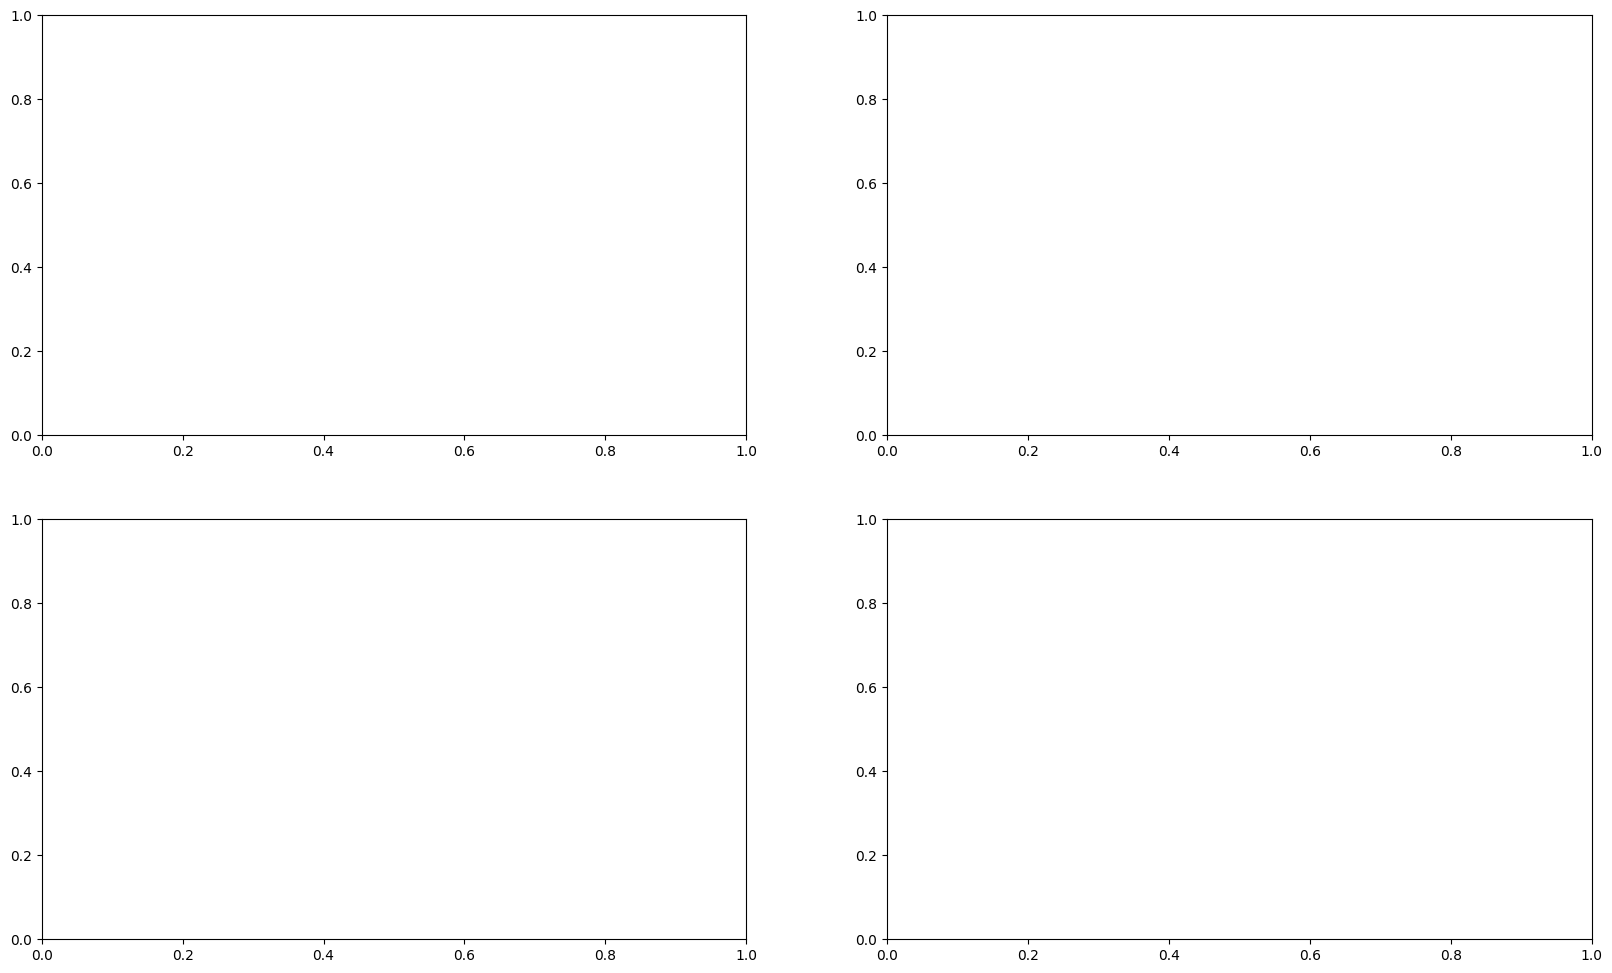

In [17]:
# ====================================================
# 9. EXECUTION & VISUALIZATION
# ====================================================
final_scores, fold_histories = run_kfold()

# Print Results
results = pd.DataFrame(final_scores)
print(f"\n{'='*20} FINAL RESULTS {'='*20}")
print(results)
print(f"Avg Dice: {results['dice'].mean():.4f}")
results.to_csv(f"{CFG.OUTPUT_DIR}final_results.csv", index=False)

# Plot History
def plot_history(histories):
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    
    def plot_metric(ax, metric, title, color):
        for h in histories: ax.plot(h[metric], alpha=0.2, color=color)
        mean = np.mean([h[metric] for h in histories], axis=0)
        ax.plot(mean, color=color, linewidth=2, label='Mean')
        ax.set_title(title)
        ax.grid(True, alpha=0.3)
        ax.legend()

    # Loss
    axes[0,0].plot(np.mean([h['train_loss'] for h in histories], 0), label='Train', color='blue')
    axes[0,0].plot(np.mean([h['val_loss'] for h in histories], 0), label='Val', color='red')
    axes[0,0].set_title("Loss")
    axes[0,0].legend()
    
    # Dice (Train vs Val)
    axes[0,1].plot(np.mean([h['train_dice'] for h in histories], 0), label='Train Dice', color='blue')
    axes[0,1].plot(np.mean([h['val_dice'] for h in histories], 0), label='Val Dice', color='green')
    axes[0,1].set_title("Dice Score (Train vs Val)")
    axes[0,1].legend()

    # IoU
    plot_metric(axes[1,0], 'val_iou', 'Val IoU', 'orange')
    
    # Precision/Recall
    axes[1,1].plot(np.mean([h['val_precision'] for h in histories], 0), label='Precision', color='purple')
    axes[1,1].plot(np.mean([h['val_recall'] for h in histories], 0), label='Recall', color='cyan')
    axes[1,1].set_title("Val Precision & Recall")
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.savefig(f"{CFG.OUTPUT_DIR}history.png")
    plt.show()

plot_history(fold_histories)

# Visualizing Predictions
def visualize_overlays():
    model = build_model()
    try:
        model.load_state_dict(torch.load(f"{CFG.OUTPUT_DIR}best_fold_1.pth"))
    except:
        print("Could not load model for viz.")
        return
    model.eval()
    
    ds = BrainDataset(df_all.sample(8, random_state=42), get_transforms('valid'))
    loader = DataLoader(ds, batch_size=4)
    images, masks = next(iter(loader))
    
    with torch.no_grad():
        preds = (model(images.to(CFG.device)).sigmoid() > 0.5).cpu()
    
    plt.figure(figsize=(15, 10))
    for i in range(4):
        img = images[i].permute(1,2,0).numpy() * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        plt.subplot(4, 3, i*3+1); plt.imshow(img); plt.title("Input"); plt.axis('off')
        plt.subplot(4, 3, i*3+2); plt.imshow(img); plt.imshow(masks[i][0], alpha=0.5, cmap='Greens'); plt.title("Truth"); plt.axis('off')
        plt.subplot(4, 3, i*3+3); plt.imshow(img); plt.imshow(preds[i][0], alpha=0.5, cmap='Reds'); plt.title("Pred"); plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_overlays()